# About Project

## 1. Giới thiệu

Bài toán trọng tâm của báo cáo này là định nghĩa chi tiết về nhiệm vụ phân vùng (segmentation) khối u glioma trên các ảnh chụp cộng hưởng từ (MRI) tiền phẫu thuật. Mục tiêu chính là gán nhãn chính xác cho từng điểm ảnh (pixel) trong ảnh, phân biệt giữa các vùng thuộc khối u và các vùng mô não khỏe mạnh. Việc phân vùng chính xác khối u và các vùng con của nó đóng vai trò then chốt trong quá trình chẩn đoán, lập kế hoạch điều trị và theo dõi tiến triển của bệnh.

## 2. Định nghĩa Bài toán

Nhiệm vụ cụ thể là phân loại từng pixel trong ảnh MRI tiền phẫu thuật thành một trong các nhãn sau:

- Nhãn 0: Pixel thuộc vùng không phải khối u.
- Nhãn 1: Pixel thuộc vùng Hoại tử và Khối u không tăng quang (NCR & NET).
- Nhãn 2: Pixel thuộc vùng Phù nề (ED).
- Nhãn 4: Pixel thuộc vùng Khối u tăng quang (ET).

Từ các nhãn cơ bản này, ba vùng quan trọng của khối u được định nghĩa để đánh giá hiệu suất phân vùng:

- Khối u tăng quang (Enhancing Tumor - ET): Được xác định bởi các pixel có nhãn là 4.
- Lõi khối u (Tumor Core - TC): Bao gồm các pixel thuộc vùng Hoại tử và Khối u không tăng quang (nhãn 1) và vùng Khối u tăng quang (nhãn 4).
- Toàn bộ khối u (Whole Tumor - WT): Bao gồm tất cả các vùng con của khối u, tức là các pixel có nhãn 1, 2 hoặc 4.

## 3. Bối cảnh và Ý nghĩa

Glioma là một loại u não nguyên phát phổ biến, có độ ác tính và hình thái rất đa dạng. Việc xác định chính xác ranh giới và các thành phần bên trong khối u là vô cùng quan trọng để bác sĩ có thể:

Đánh giá kích thước và vị trí khối u.
Lập kế hoạch phẫu thuật, xạ trị hoặc các phương pháp điều trị khác một cách hiệu quả.
Theo dõi sự phát triển của khối u theo thời gian.
Nghiên cứu về đặc điểm và tiến triển của bệnh.
Phân vùng thủ công bởi các chuyên gia y tế là một quá trình tốn thời gian và có thể bị sai sót do sự khác biệt giữa các người quan sát. Do đó, việc phát triển các phương pháp phân vùng tự động và chính xác là một nhu cầu cấp thiết.

## 4. Dữ liệu Đầu vào

Dữ liệu đầu vào cho bài toán này là các ảnh chụp MRI tiền phẫu thuật của bệnh nhân có khối u glioma. Các loại chuỗi xung MRI thường được sử dụng bao gồm T1-weighted, T1-weighted with contrast enhancement (T1Gd), T2-weighted và FLAIR. Mỗi chuỗi xung cung cấp thông tin khác nhau về cấu trúc và đặc điểm của mô não, giúp phân biệt rõ hơn giữa các vùng khối u và mô não lành.

## 5. Mục tiêu Đánh giá

Hiệu suất của các phương pháp phân vùng sẽ được đánh giá dựa trên khả năng xác định chính xác ba vùng con chính của khối u (ET, TC, WT) so với nhãn chuẩn (ground truth) được cung cấp bởi các chuyên gia. Các chỉ số đánh giá phổ biến bao gồm Dice score, Jaccard index (Intersection over Union - IoU), và Hausdorff distance.

In [1]:
import tensorflow as tf
print(tf.__version__)

2025-05-19 05:29:05.874706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747632546.098868      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747632546.162252      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


# Import Libraries & Tools

In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif

# ml libs
import keras
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from tensorflow.keras import backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
import random
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-3wmtmjmt
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-3wmtmjmt
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6631 sha256=e5f3b3f064961c847862471d6b90c7e5aed50af817ba4c0f304a39b281ecab28
  Stored in directory: /tmp/pip-ephem-wheel-cache-8z_d13is/wheels/de/6d/35/5b931fbea2039fbd2ac937828c719c3cdd70953235af24b9ab
Successfully built gif_your_nifti


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',          # Nhãn 0: Vùng không phải là khối u
    1 : 'NECROTIC/CORE',      # Nhãn 1: Vùng hoại tử hoặc lõi khối u không tăng quang (NCR/NET)
    2 : 'EDEMA',              # Nhãn 2: Vùng phù nề quanh khối u
    3 : 'ENHANCING'           # Nhãn 3: Vùng khối u tăng quang (trong dữ liệu gốc có nhãn 4, đã được chuyển đổi)
}

# Thông tin về số lượng slice trên mỗi volume và phạm vi sử dụng
# Thông thường có 155 slice trên mỗi volume MRI 3D.
# Để bắt đầu từ slice thứ 22 (index) và sử dụng 100 slice liên tiếp,
# bỏ qua 22 slice đầu tiên và (155 - 22 - 100 = 33) slice cuối cùng.
VOLUME_SLICES = 100          # Số lượng slice được sử dụng từ mỗi volume
VOLUME_START_AT = 22         # slice đầu tiên (index) của volume được đưa vào xử lý

# Image data descriptions

Tất cả các ảnh MRI đa kênh trong bộ dữ liệu BraTS đều được cung cấp dưới dạng tệp NIfTI (.nii.gz) – một định dạng phổ biến trong y học để lưu trữ ảnh não chụp bằng MRI và thể hiện các thông số chụp khác nhau.

Các loại ảnh MRI trong bộ dữ liệu bao gồm:

1. **T1**: Ảnh T1 gốc (T1-weighted), chụp theo mặt phẳng dọc (sagittal) hoặc ngang (axial), dạng 2D, với độ dày slice từ 1–6 mm.

2. **T1c**: Ảnh T1 có tiêm thuốc cản quang Gadolinium (T1-weighted contrast-enhanced), chụp 3D với kích thước voxel đẳng hướng 1 mm đối với hầu hết bệnh nhân.

3. **T2**: Ảnh T2 (T2-weighted), chụp mặt phẳng ngang, dạng 2D, với độ dày slice từ 2–6 mm.

4. **FLAIR**: Ảnh FLAIR (một loại ảnh T2 đặc biệt), chụp ở các mặt phẳng ngang, dọc hoặc chéo, dạng 2D, với độ dày slice từ 2–6 mm.

Dữ liệu được thu thập theo nhiều giao thức lâm sàng khác nhau và từ nhiều loại máy MRI, đến từ 19 cơ sở y tế khác nhau. Tất cả ảnh MRI đều đã được chú thích (phân vùng khối u) thủ công, bởi từ 1 đến 4 người đánh giá, tuân theo cùng một quy trình ghi nhãn, và các chú thích này đều đã được kiểm duyệt bởi các bác sĩ chẩn đoán hình ảnh thần kinh có kinh nghiệm.

Các vùng được chú thích bao gồm:

- **ET** (Enhancing Tumor) – vùng khối u tăng tín hiệu sau khi tiêm thuốc cản quang (gán nhãn 4),

- **ED (Edema)** – vùng phù nề quanh khối u (gán nhãn 2),

- **NCR/NET (Necrotic and Non-Enhancing Tumor Core)** – vùng khối u không tăng tín hiệu hoặc hoại tử (gán nhãn 1).

Dữ liệu được phân phối sau khi đã qua xử lý trước, bao gồm:

- **Căn chỉnh (co-registration)** về cùng một mẫu giải phẫu chuẩn,

- **Nội suy (interpolation)** về cùng độ phân giải: 1 mm³,

- **Loại bỏ hộp sọ (skull-stripping)** để chỉ giữ lại phần não.


In [ ]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# LOAD MRI SCANS AND SEGMENTATION MASK FOR A SAMPLE CASE
# Sử dụng thư viện nibabel để đọc dữ liệu ảnh NIfTI (.nii)
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# VISUALIZE THE LOADED DATA USING MATPLOTLIB
# Tạo một figure và một mảng các subplot (5 subplot trên một hàng) với kích thước 20x10 inch
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25 # Chọn một offset slice để hiển thị (ví dụ: slice gần giữa)

# Hiển thị slice thứ (giữa - slice_w) của ảnh FLAIR trên subplot đầu tiên (ax1) với colormap 'gray'
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')

# Hiển thị slice tương ứng của ảnh T1 trên subplot thứ hai (ax2) với colormap 'gray'
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')

# Hiển thị slice tương ứng của ảnh T1 sau tiêm thuốc cản quang (T1ce) trên subplot thứ ba (ax3) với colormap 'gray'
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')

# Hiển thị slice tương ứng của ảnh T2 trên subplot thứ tư (ax4) với colormap 'gray'
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')

# Hiển thị slice tương ứng của mask phân vùng (segmentation mask) trên subplot thứ năm (ax5) với colormap mặc định
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Text(0.5, 1.0, 'Mask')

**In toàn bộ dữ liệu nifti -> In từng slice từ dữ liệu 3D**

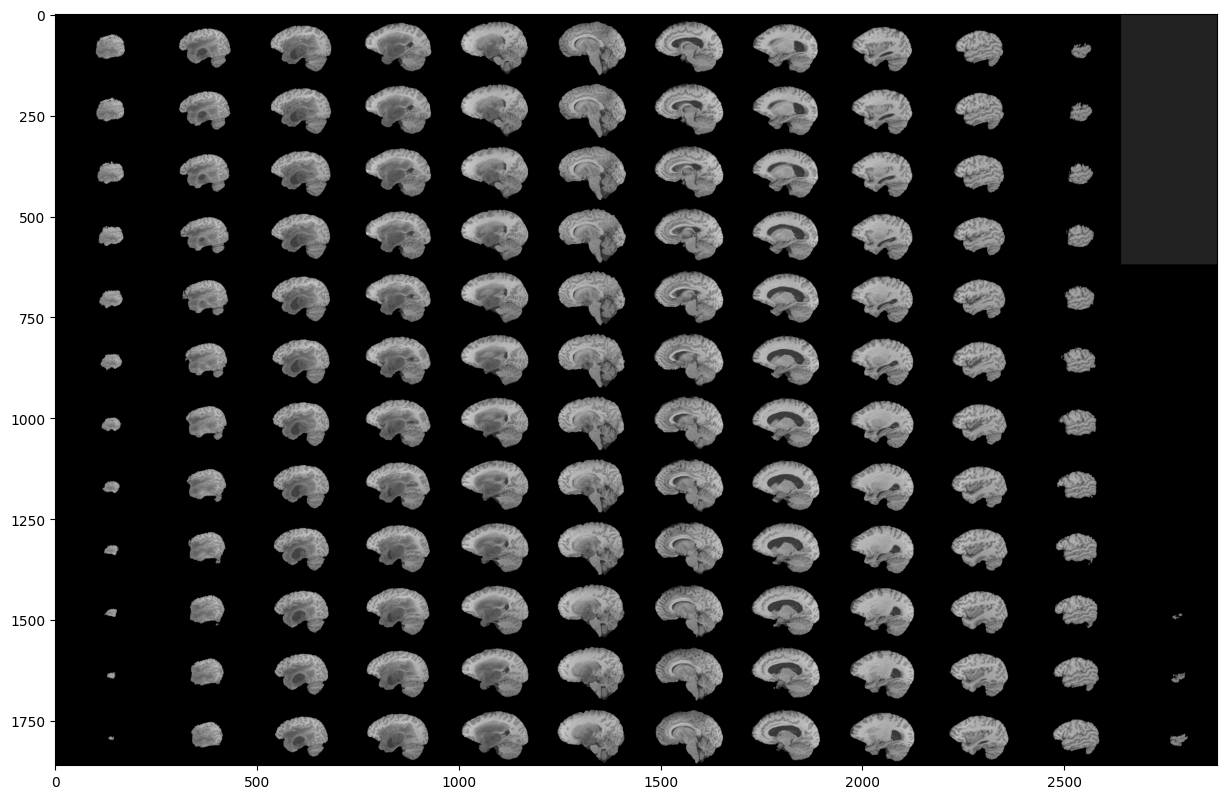

In [5]:
# Tạo một figure và một subplot duy nhất với kích thước 15x15 inch
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))

# Hiển thị một montage (tập hợp các slice) của ảnh T1
ax1.imshow(rotate(montage(test_image_t1[50:-50, :, :]), 90, resize=True), cmap='gray')

**Hiển thị segmentation cho từng slice**

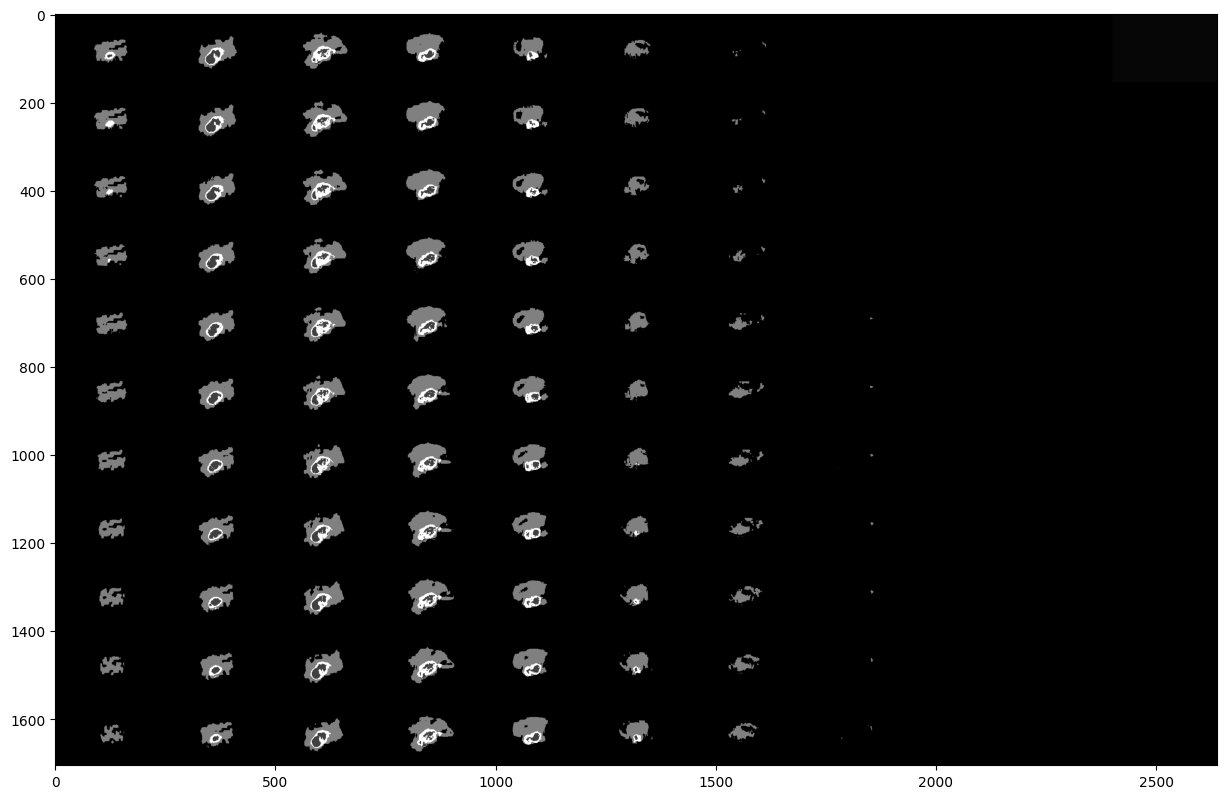

In [6]:
# Tạo một figure và một subplot duy nhất với kích thước 15x15 inch
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))

# Hiển thị một montage (tập hợp các slice) của mask phân vùng (test_mask)
ax1.imshow(rotate(montage(test_mask[60:-60, :, :]), 90, resize=True), cmap='gray')

In [7]:
# Sao chép ảnh FLAIR NIfTI để tạo GIF
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')

# Tạo GIF từ ảnh NIfTI đã sao chép
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Gif representation of slices in 3D volume**
<img src="https://media1.tenor.com/images/15427ffc1399afc3334f12fd27549a95/tenor.gif?itemid=20554734">

**Hiển thị các phân đoạn khối u dùng các hiệu ứng khác nhau**

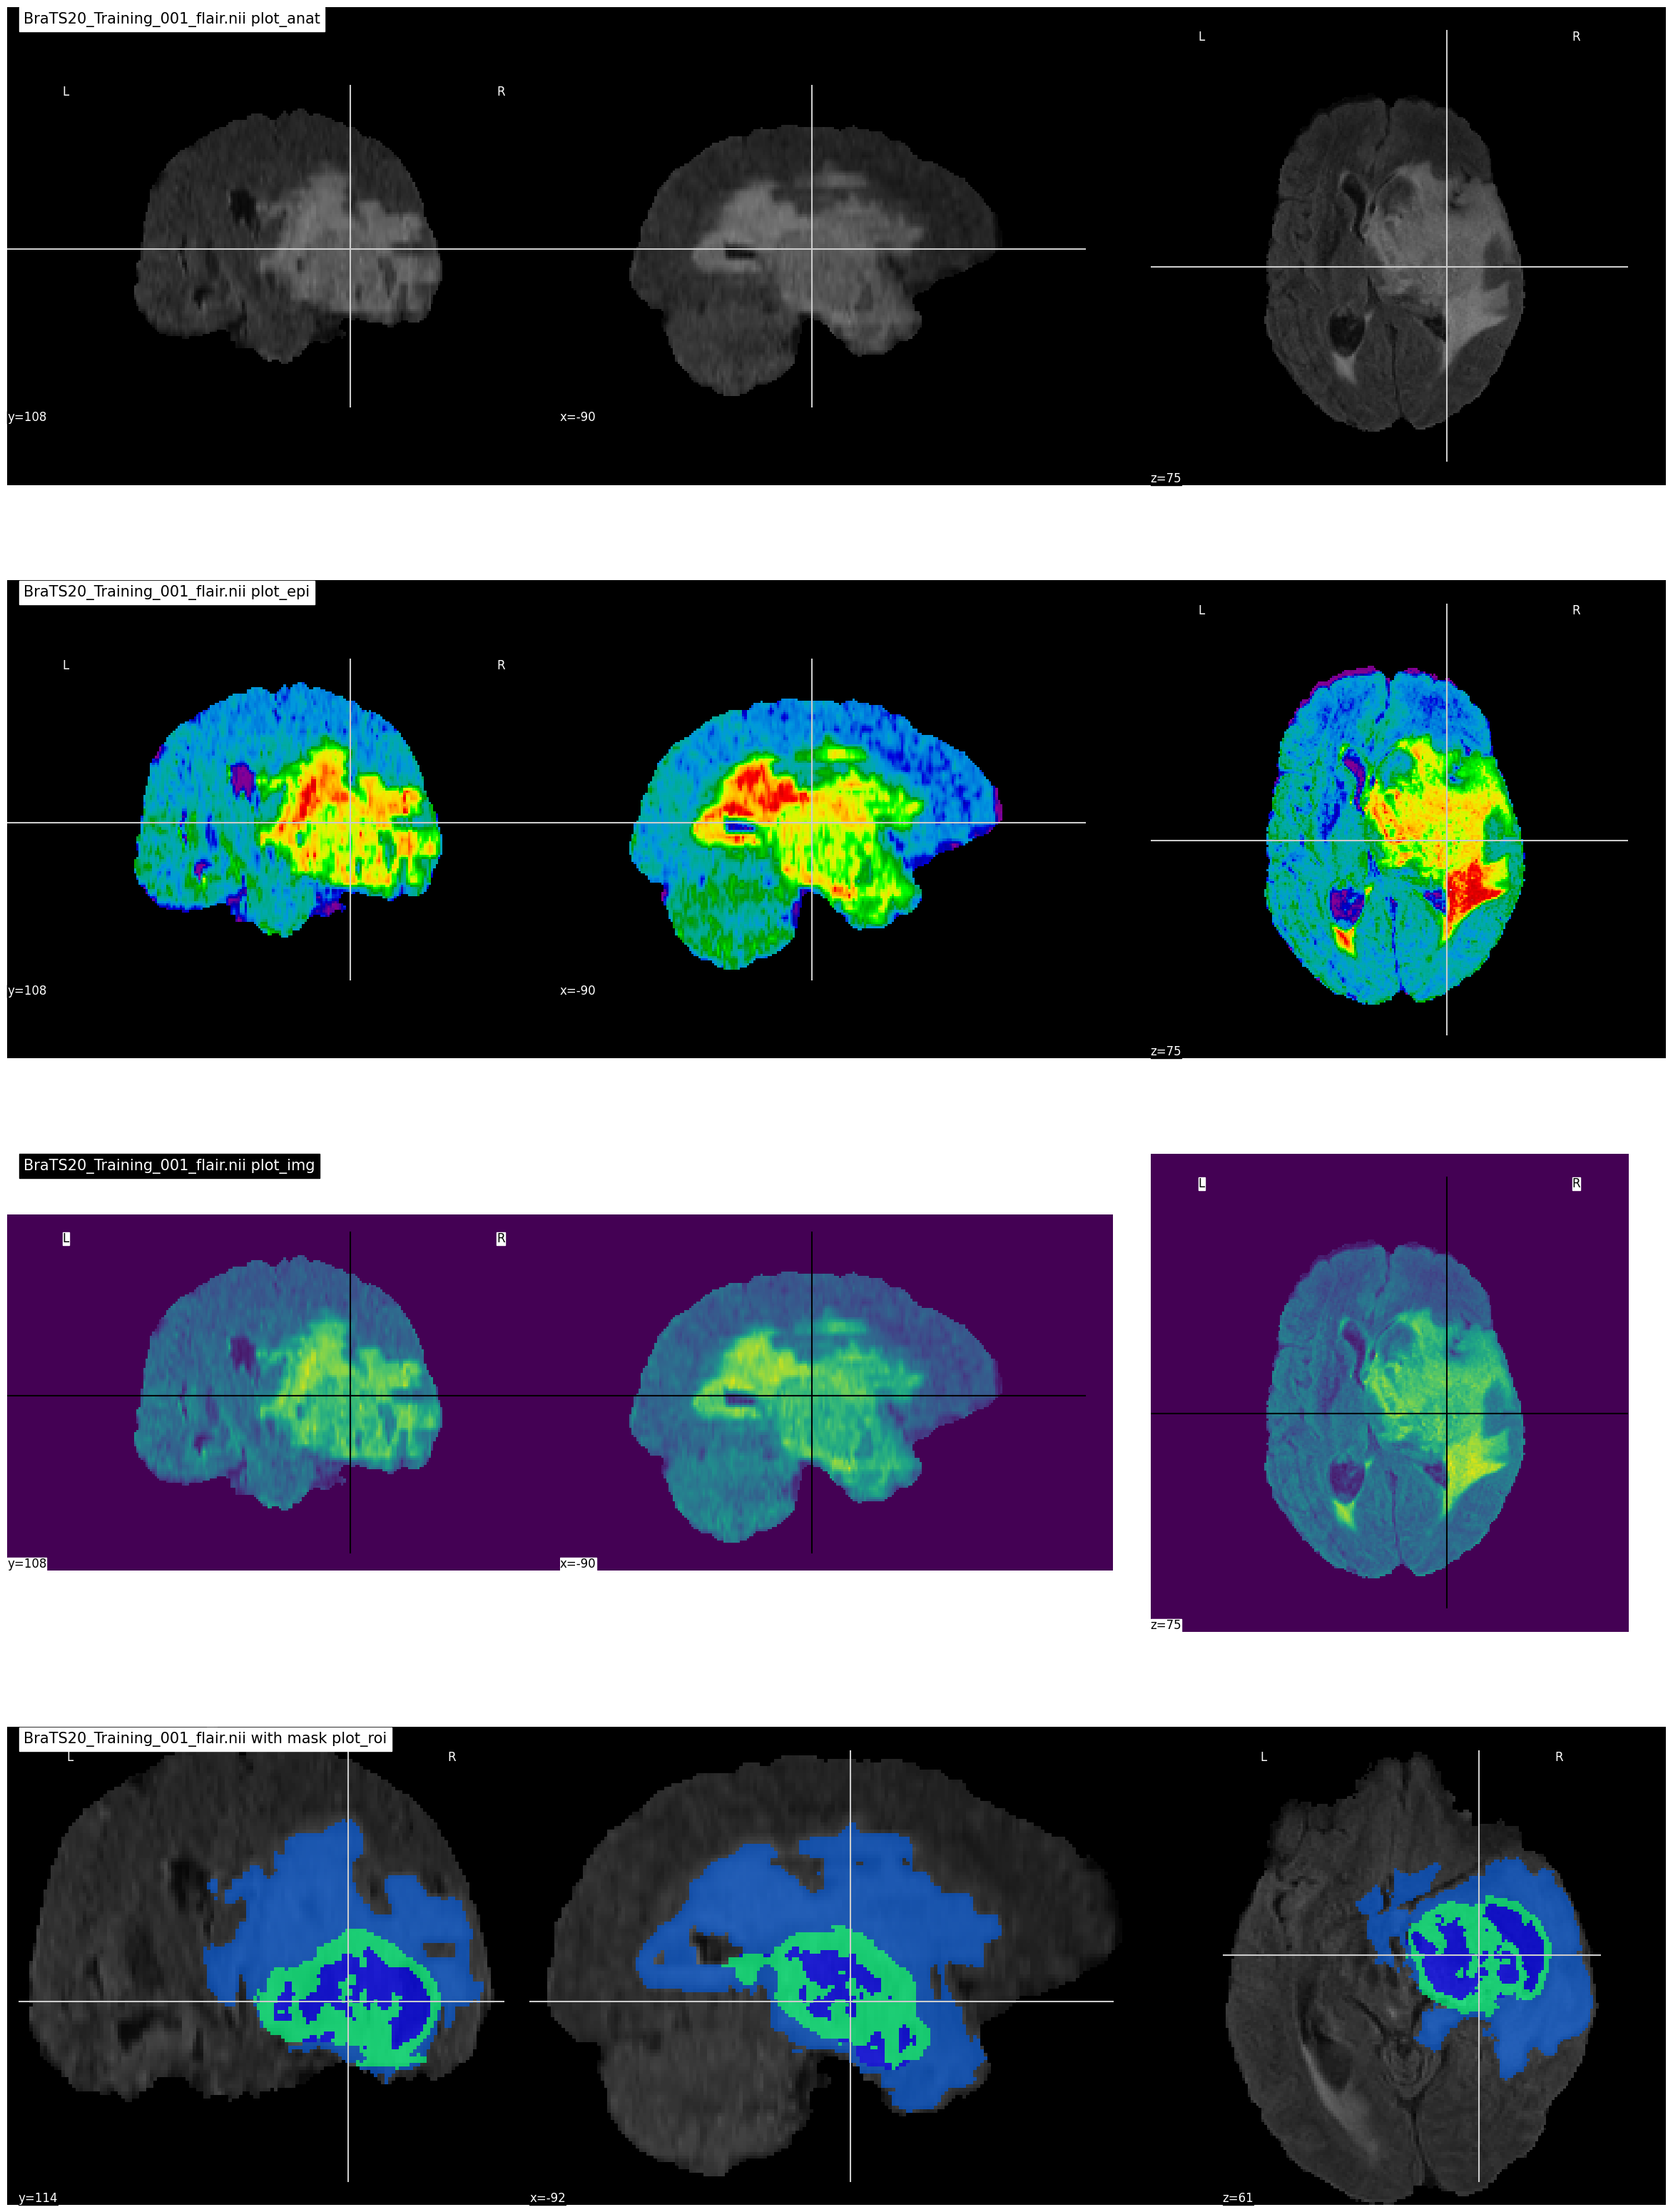

In [8]:
# Tải ảnh MRI FLAIR và mask phân vùng từ tệp NIfTI
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

# Tạo một figure với 4 subplot, kích thước 30x40 inch
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

# Hiển thị ảnh giải phẫu (anatomical)
nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

# Hiển thị ảnh EPI (echo-planar imaging), thường dùng cho fMRI
nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

# Hiển thị ảnh tổng quát (có thể là các slice khác nhau)
nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

# Hiển thị mask phân vùng chồng lên ảnh nền (ảnh FLAIR)
nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='winter')

# Hiển thị toàn bộ figure với các subplot
plt.show()

# Loss function
**Dice coefficient**

In [9]:
# Tính hệ số Dice trung bình trên 4 lớp
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_dice = 0.0

    for i in range(class_num):
        # Dùng tf.reshape
        y_true_f = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_f = tf.reshape(y_pred[:, :, :, i], [-1])
        # Tính giao nhau giữa y_true và y_pred
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        # Tính Dice cho lớp i
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_dice += dice

    return total_dice / class_num

# Tính hệ số Dice cho lớp hoại tử (necrotic - kênh thứ 1).
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)
    
# Tính hệ số Dice cho lớp phù nề (edema - kênh thứ 2).
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)
    
# Tính hệ số Dice cho lớp enhancing (enhancing - kênh thứ 3).
def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)
    
# Tính độ chính xác (Precision).
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Tính độ nhạy (Sensitivity) hay Recall.
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Tính độ đặc hiệu (Specificity).
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Define Model

In [10]:
IMG_SIZE = 128  # Kích thước chiều rộng và chiều cao của ảnh đầu vào

def build_unet(inputs, ker_init, dropout):
    # Phần Encoder (Descending path)
    # Block 1
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)

    # Block 3
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 4
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom block
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Phần Decoder (Ascending path)
    # Block 6
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    # Block 7
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    # Block 8
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Block 9
    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    # Output layer
    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)

K.clear_session()

# Định nghĩa lớp đầu vào cho mô hình
input_layer = Input((IMG_SIZE, IMG_SIZE, 2)) # Giả sử ảnh đầu vào có kích thước 128x128 và 2 kênh

# Xây dựng mô hình U-Net
model = build_unet(input_layer, 'he_normal', 0.2)

# Compile mô hình với hàm loss, optimizer và các metrics đánh giá
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy',
                       tf.keras.metrics.MeanIoU(num_classes=4),
                       dice_coef,
                       precision,
                       sensitivity,
                       specificity,
                       dice_coef_necrotic,
                       dice_coef_edema,
                       dice_coef_enhancing])

I0000 00:00:1747632594.007001      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Load data

In [11]:
# Tạo một danh sách chứa đường dẫn
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Loại bỏ thư mục có định dạng tên không đúng.
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

# Chuyển đổi danh sách đường dẫn thư mục thành danh sách các ID thư mục.
def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):
        # Lấy phần tên thư mục cuối cùng từ đường dẫn bằng cách tìm vị trí cuối cùng của dấu '/'
        # và lấy chuỗi con bắt đầu từ vị trí đó + 1.
        x.append(dirList[i][dirList[i].rfind('/') + 1:])
    return x

# Tạo danh sách các ID (tên thư mục) từ danh sách đường dẫn thư mục huấn luyện và xác thực.
train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Chia tập dữ liệu ID thành tập huấn luyện/kiểm tra ban đầu và tập xác thực.
# test_size=0.2 có nghĩa là 20% dữ liệu sẽ được dành cho tập xác thực (val_ids).
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)

# Chia tập dữ liệu huấn luyện/kiểm tra ban đầu thành tập huấn luyện và tập kiểm tra cuối cùng.
# test_size=0.15 có nghĩa là 15% của tập train_test_ids sẽ được dành cho tập kiểm tra (test_ids).
# Do đó, tỷ lệ phân chia ban đầu cho tập huấn luyện, kiểm tra và xác thực là khoảng 68% (0.8 * 0.85), 12% (0.8 * 0.15) và 20%.
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

**Override Keras sequence DataGenerator class**

In [12]:
# Khởi tạo transform augmentation
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.1),
    A.GridDistortion(p=0.1),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
])

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True, augment_data=True):
        'Initialization'
        self.dim = dim  # Kích thước của ảnh đầu vào (chiều cao, chiều rộng)
        self.batch_size = batch_size  # Số lượng mẫu (slice) trong một batch
        self.list_IDs = list_IDs  # Danh sách các ID bệnh nhân để tạo dữ liệu
        self.n_channels = n_channels  # Số lượng kênh của ảnh đầu vào (ví dụ: FLAIR và T1ce là 2)
        self.shuffle = shuffle  # Xác định xem có xáo trộn thứ tự ID sau mỗi epoch hay không
        self.augment_data = augment_data  # Thêm tham số cho việc kích hoạt augment
        self.on_epoch_end()  # Gọi hàm này khi khởi tạo để thiết lập thứ tự ban đầu của dữ liệu

    def __len__(self):
        'Denotes the number of batches per epoch'
        # Tính số lượng batch trên mỗi epoch bằng cách chia tổng số ID cho kích thước batch và làm tròn xuống
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Lấy danh sách các index cho batch hiện tại
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Tạo danh sách các ID bệnh nhân cho batch hiện tại
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Tạo dữ liệu (ảnh và mask) cho batch hiện tại
        X, y = self.__data_generation(Batch_ids)

        return X, y  # Trả về batch ảnh đầu vào (X) và mask mục tiêu (y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # Tạo một mảng các index từ 0 đến tổng số ID
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            # Nếu shuffle là True, xáo trộn ngẫu nhiên các index sau mỗi epoch
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim))  # dùng self.dim thay vì hardcode 240
    
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()
    
            for j in range(VOLUME_SLICES):
                flair_slice = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                ce_slice = cv2.resize(ce[:, :, j + VOLUME_START_AT], self.dim)
                seg_slice = cv2.resize(seg[:, :, j + VOLUME_START_AT], self.dim, interpolation=cv2.INTER_NEAREST)
    
                if self.augment_data:
                    image = np.stack([flair_slice, ce_slice], axis=-1)
                    mask = seg_slice.astype(np.uint8)
                    augmented = augment(image=image, mask=mask)
                    image_aug = augmented['image']
                    mask_aug = augmented['mask']
                else:
                    image_aug = np.stack([flair_slice, ce_slice], axis=-1)
                    mask_aug = seg_slice
    
                X[j + VOLUME_SLICES * c] = image_aug
                y[j + VOLUME_SLICES * c] = mask_aug
    
        y[y == 4] = 3
        mask_onehot = tf.one_hot(y.astype(np.uint8), 4)
        Y = tf.image.resize(mask_onehot, self.dim)
    
        return X / np.max(X), Y

# Tạo các instance của DataGenerator cho tập huấn luyện, xác thực và kiểm tra
training_generator = DataGenerator(train_ids, augment_data=True)
valid_generator = DataGenerator(val_ids, augment_data=False)
test_generator = DataGenerator(test_ids, augment_data=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**Number of data used**
for training / testing / validation

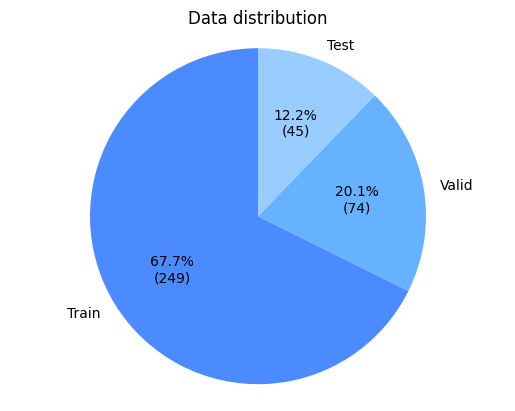

In [13]:
def showDataLayout():
    labels = ["Train", "Valid", "Test"]
    sizes = [len(train_ids), len(val_ids), len(test_ids)]

    total = sum(sizes)

    colors = ['#4C8BFF', '#66B2FF', '#99CCFF']

    def make_autopct(sizes):
        def my_autopct(pct):
            count = int(round(pct * total / 100.0))
            return '{:.1f}%\n({:d})'.format(pct, count)
        return my_autopct

    plt.pie(sizes, labels=labels, colors=colors, autopct=make_autopct(sizes), startangle=90)
    plt.axis('equal') 
    plt.title('Data distribution')
    plt.show()

showDataLayout()

**Add callback for training process**

In [14]:
# Khởi tạo callback CSVLogger để ghi lại lịch sử huấn luyện vào một tệp CSV
# 'training.log': Tên của tệp CSV sẽ được tạo hoặc ghi đè.
# separator=',': Sử dụng dấu phẩy làm dấu phân cách giữa các giá trị trong tệp CSV.
# append=False: Nếu tệp 'training.log' đã tồn tại, nó sẽ bị ghi đè khi bắt đầu huấn luyện.
csv_logger = CSVLogger('training.log', separator=',', append=False)

# Tạo một danh sách các callbacks sẽ được sử dụng trong quá trình huấn luyện mô hình
callbacks = [
    # Callback ReduceLROnPlateau: Giảm learning rate khi độ đo giám sát (validation loss) ngừng cải thiện.
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # Độ đo cần theo dõi: validation loss
        factor=0.2,        # Hệ số nhân để giảm learning rate (mới_lr = cũ_lr * factor)
        patience=2,        # Số lượng epoch mà validation loss không cải thiện thì learning rate sẽ giảm
        min_lr=0.000001,   # Giá trị learning rate tối thiểu
        verbose=1          # Hiển thị thông báo khi learning rate bị giảm
    ),
    # Callback CSVLogger: Ghi lại các thông tin về loss và metrics sau mỗi epoch vào tệp CSV.
    csv_logger
]

# Train model

In [15]:
K.clear_session()

history =  model.fit(
    training_generator,
    epochs=35,
    callbacks= callbacks,
    validation_data = valid_generator
)  

model.save("3D_MRI_Brain_tumor_segmentation.h5")

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747632613.030362     128 service.cc:148] XLA service 0x7e6cec003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747632613.031105     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747632614.113929     128 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747632640.982776     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 247s 818ms/step - accuracy: 0.9694 - dice_coef: 0.2576 - dice_coef_edema: 0.0998 - dice_coef_enhancing: 0.0313 - dice_coef_necrotic: 0.0426 - loss: 0.1704 - mean_io_u: 0.4905 - precision: 0.9585 - sensitivity: 0.9452 - specificity: 0.9944 - val_accuracy: 0.9836 - val_dice_coef: 0.2584 - val_dice_coef_edema: 0.0617 - val_dice_coef_enhancing: 0.0113 - val_dice_coef_necrotic: 0.0183 - val_loss: 0.0904 - val_mean_io_u: 0.5000 - val_precision: 0.9836 - val_sensitivity: 0.9835 - val_specificity: 0.9945 - learning_rate: 0.0010
Epoch 2/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 334ms/step - accuracy: 0.9835 - dice_coef: 0.2678 - dice_coef_edema: 0.1220 - dice_coef_enhancing: 0.0340 - dice_coef_necrotic: 0.0489 - loss: 0.0868 - mean_io_u: 0.5023 - precision: 0.9835 - sensitivity: 0.9835 - specificity: 0.9945 - val_accuracy: 0.9836 - val_dice_coef: 0.2805 - val_dice_coef_edema: 0.1488 - val_dice_coef_enhancing: 0.0438 - val_dice_coef_necrotic: 0.0710 - val_loss: 0.0645 - va

**Visualize the training process**

In [16]:
# Load model
model = tf.keras.models.load_model("3D_MRI_Brain_tumor_segmentation.h5", custom_objects={
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
})

# Tải ảnh MRI từ tệp NIfTI, chọn một slice cụ thể (nếu được chỉ định), thay đổi kích thước slice và chuẩn hóa cường độ pixel.
def preprocess_image(image_file, slice_index=None):
    # Load the NIfTI file
    img = nib.load(image_file).get_fdata()
    # Sử dụng thư viện nibabel để tải dữ liệu ảnh từ tệp NIfTI.

    # Select a specific slice if needed
    if slice_index is not None:
        img = img[:, :, slice_index]
    # Nếu `slice_index` được cung cấp, chọn slice tương ứng dọc theo trục thứ ba (trục Z).

    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Sử dụng thư viện OpenCV để thay đổi kích thước slice ảnh thành kích thước mong muốn (IMG_SIZE x IMG_SIZE).

    # Normalize the image
    img_resized = img_resized / np.max(img_resized)
    # Chuẩn hóa cường độ pixel của ảnh đã resize bằng cách chia cho giá trị pixel lớn nhất.
    # Điều này đưa các giá trị pixel về khoảng [0, 1].

    return img_resized
    
# Tiền xử lý hai ảnh MRI (ví dụ: FLAIR và T1ce) ở cùng một slice và đưa ra dự đoán phân vùng sử dụng mô hình đã tải.
def predict(image_paths, slice_index):
    # Khởi tạo một mảng numpy để chứa batch đầu vào cho mô hình.
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2))

    # Tiền xử lý slice từ ảnh đầu tiên (ví dụ: FLAIR) và gán nó vào kênh đầu tiên của mảng đầu vào.
    X[0, :, :, 0] = preprocess_image(image_paths[0], slice_index)
    # Tiền xử lý slice từ ảnh thứ hai (ví dụ: T1ce) và gán nó vào kênh thứ hai của mảng đầu vào.
    X[0, :, :, 1] = preprocess_image(image_paths[1], slice_index)

    pred = model.predict(X)

    return np.argmax(pred[0], axis=-1)

# Danh sách đường dẫn đến hai tệp ảnh MRI (FLAIR và T1ce) cho một trường hợp ví dụ.
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1ce.nii'
]

# Chỉ số của slice cụ thể mà chúng ta muốn thực hiện dự đoán.
slice_index = 75 

# Gọi hàm `predict` để lấy kết quả dự đoán phân vùng cho slice đã chọn.
prediction = predict(image_paths, slice_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [17]:
# Chuyển đổi ma trận xác suất dự đoán thành ma trận các lớp dự đoán bằng cách lấy lớp có xác suất cao nhất cho mỗi pixel.
def get_classification(pred):
    # Tìm chỉ số của lớp có xác suất cao nhất dọc theo trục cuối cùng.
    class_predictions = np.argmax(pred, axis=-1)
    return class_predictions
    
# Hàm get_classification sẽ chuyển đổi bản đồ xác suất này
# thành một bản đồ phân vùng với các nhãn lớp.
get_classification(np.expand_dims(prediction, axis=0))

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 96, 92, 90, 86, 85, 84, 83, 83, 84, 81, 80,
        79, 79, 78, 78, 78, 78, 78, 78, 79, 80, 80,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

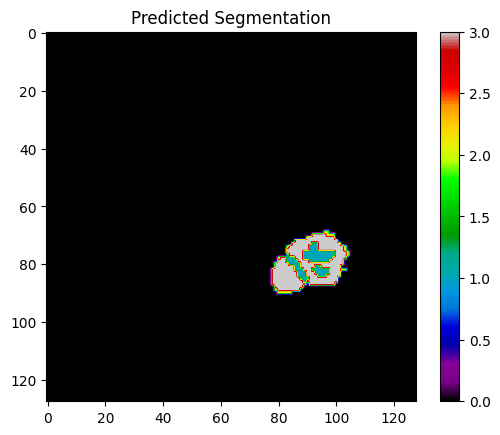

In [18]:
def visualize_prediction(prediction):
    """Hiển thị ảnh dự đoán phân vùng với bảng màu 'nipy_spectral'."""
    plt.imshow(prediction, cmap='nipy_spectral')
    plt.title('Predicted Segmentation')
    plt.colorbar()
    plt.show()

visualize_prediction(prediction)

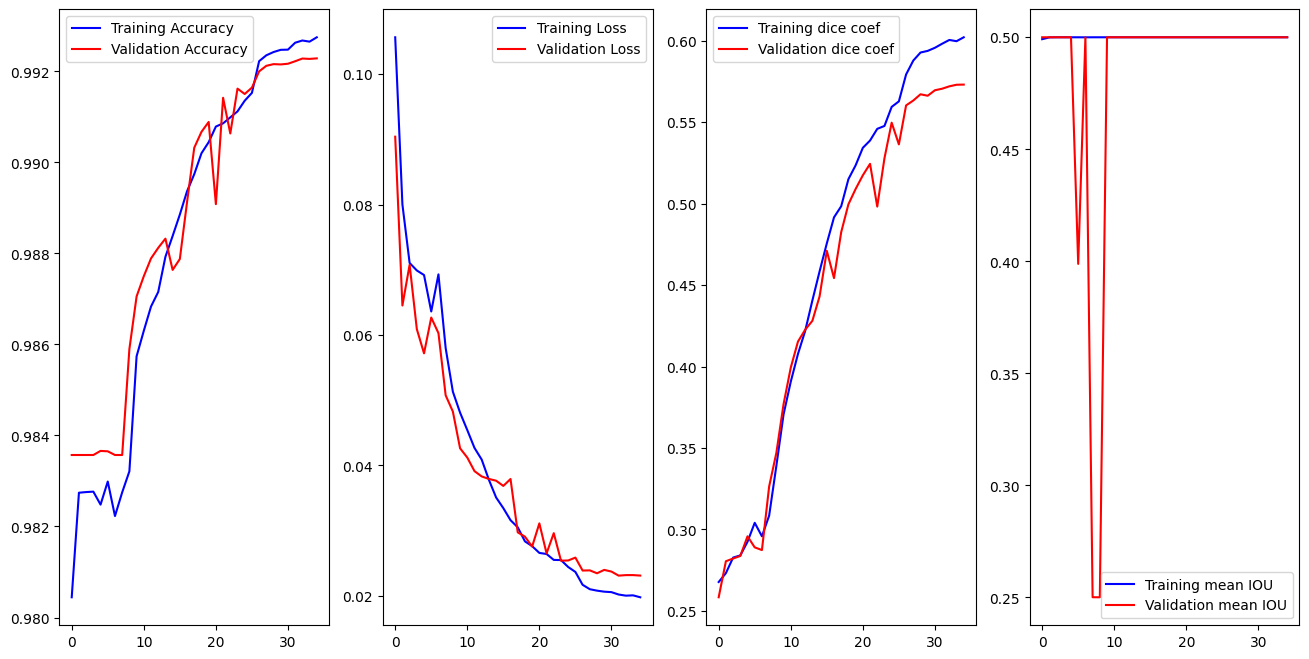

In [19]:
model = keras.models.load_model('3D_MRI_Brain_tumor_segmentation.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                    "dice_coef": dice_coef,
                                                    "precision": precision,
                                                    "sensitivity":sensitivity,
                                                    "specificity":specificity,
                                                    "dice_coef_necrotic": dice_coef_necrotic,
                                                    "dice_coef_edema": dice_coef_edema,
                                                    "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

# Vẽ Accuracy
ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

# Vẽ loss
ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

# Vẽ Dice coefficient
ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

# Vẽ Mean IOU
ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples 

In [20]:
# Tải và trả về toàn bộ volume ảnh MRI từ đường dẫn đã cho.
def imageLoader(path):
    image = nib.load(path).get_fdata()
    return np.array(image)

# Tải ảnh MRI và mask phân vùng từ các tệp NIfTI trong các thư mục con,
# lấy các slice và thay đổi kích thước chúng.
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        # Tìm đường dẫn đầy đủ đến tệp MRI theo loại đã chỉ định
        fullPath = glob.glob(os.path.join(i, f'*{mriType}*'))[0]
        # Tải toàn bộ volume MRI
        currentScanVolume = imageLoader(fullPath)
        # Tìm đường dẫn đầy đủ đến tệp mask phân vùng
        currentMaskVolume = imageLoader(glob.glob(os.path.join(i, '*seg*'))[0])
        # Lặp qua từng slice trong volume 3D
        for j in range(0, currentScanVolume.shape[2]):
            # Thay đổi kích thước slice MRI
            scan_img = cv2.resize(currentScanVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            # Thay đổi kích thước slice mask
            mask_img = cv2.resize(currentMaskVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            # Thêm chiều kênh cho ảnh scan (cho mô hình CNN)
            scans.append(scan_img[..., np.newaxis])
            # Thêm chiều kênh cho ảnh mask
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 930ms/step


<Figure size 1800x5000 with 0 Axes>

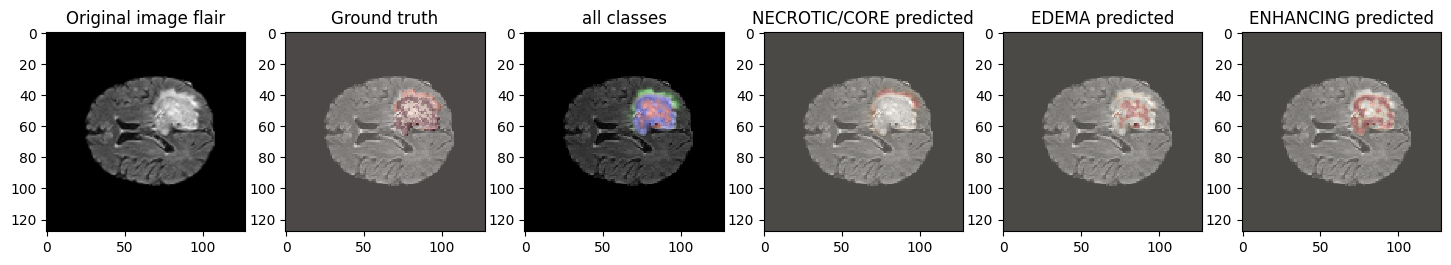

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

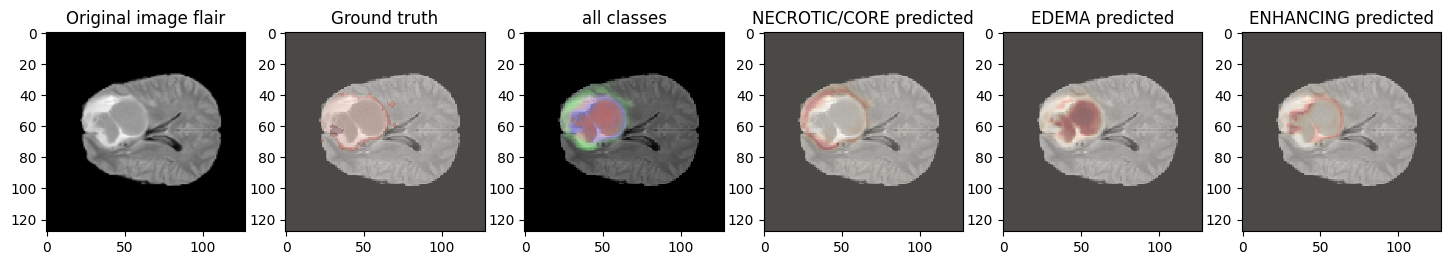

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

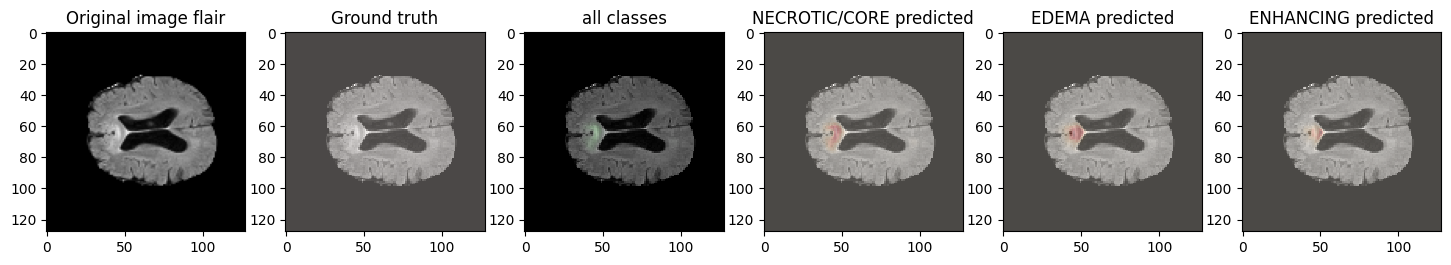

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

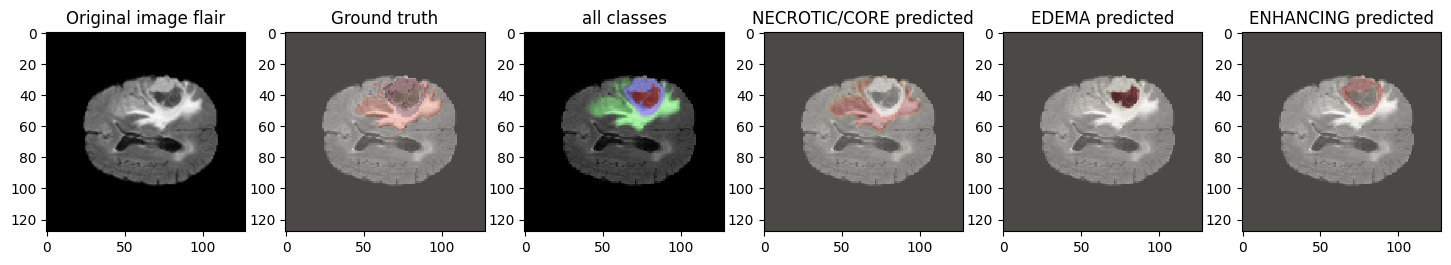

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

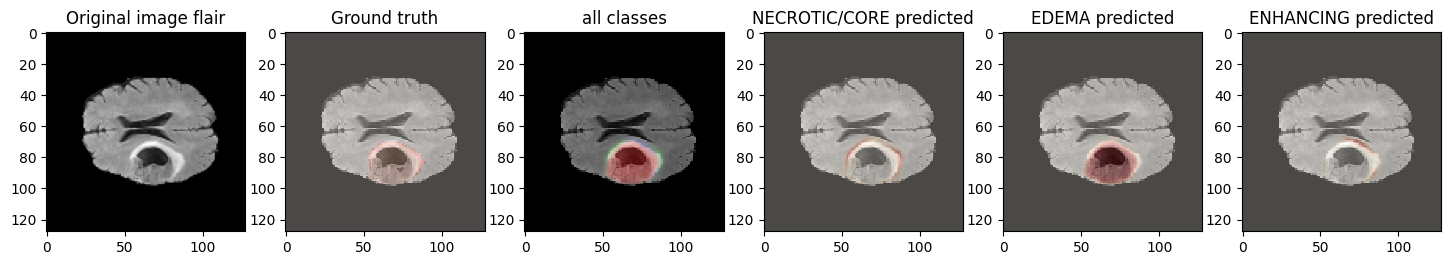

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

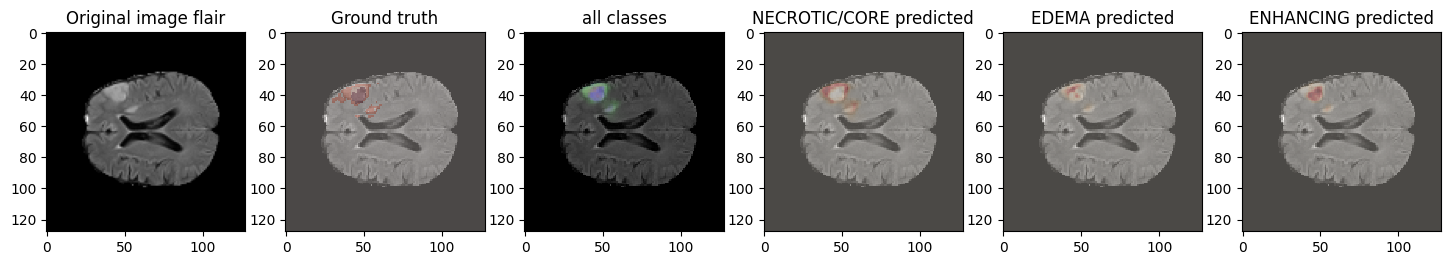

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

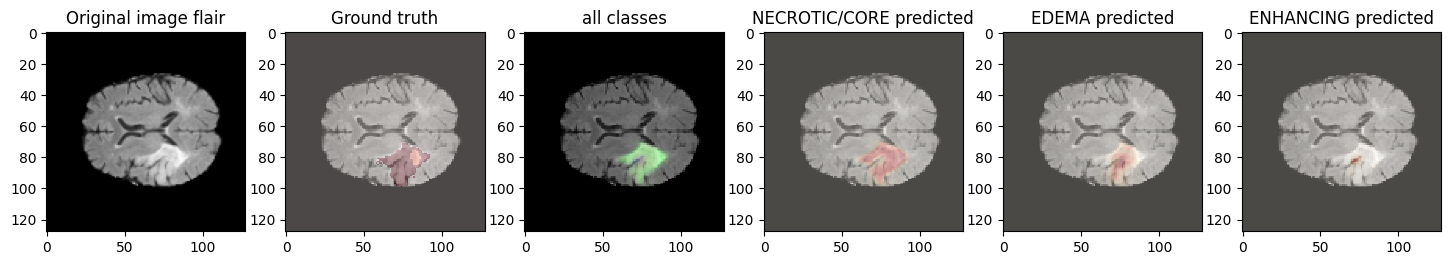

In [21]:
# Dự đoán phân vùng
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    # y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    # vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
    # seg=nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        # y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X / np.max(X), verbose=1)

# Hiển thị ảnh gốc, ground truth và các lớp dự đoán cho một lát cắt cụ thể của một ca bệnh.
def showPredictsById(case, start_slice=60):

    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6): 
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)  # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


# Hiển thị kết quả dự đoán cho một số ca bệnh trong tập kiểm tra
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

# Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1000x500 with 0 Axes>

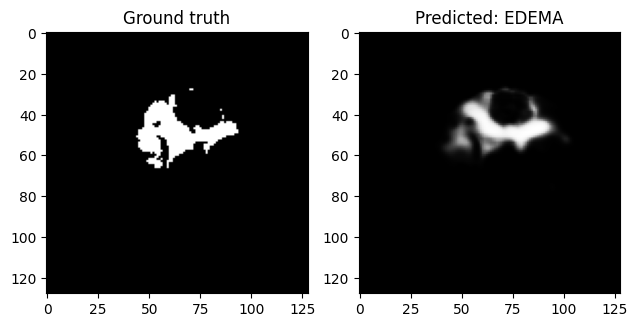

In [22]:
case = test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

i = 40  # Lát cắt tại vị trí
eval_class = 2  #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt_eval = np.copy(gt) # Tạo bản sao để không sửa đổi ground truth gốc
gt_eval[gt_eval != eval_class] = 0 # Đặt tất cả các lớp khác thành 0
gt_eval[gt_eval == eval_class] = 1 # Đặt lớp đánh giá thành 1 (mask nhị phân)

resized_gt = cv2.resize(gt_eval[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
predicted_class = cv2.resize(p[i, :, :, eval_class], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)


plt.figure(figsize=(10, 5))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground truth')
axarr[1].imshow(predicted_class, cmap="gray")
axarr[1].title.set_text(f'Predicted: {SEGMENT_CLASSES[eval_class]}')
plt.tight_layout()
plt.show()

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy',
                       tf.keras.metrics.MeanIoU(num_classes=4),
                       dice_coef,
                       precision,
                       sensitivity,
                       specificity,
                       dice_coef_necrotic,
                       dice_coef_edema,
                       dice_coef_enhancing])

# Đánh giá mô hình
print("Đánh giá trên dữ liệu kiểm tra")
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test acc:", results)

Đánh giá trên dữ liệu kiểm tra


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 540ms/step - accuracy: 0.9922 - dice_coef: 0.5656 - dice_coef_edema: 0.6279 - dice_coef_enhancing: 0.5770 - dice_coef_necrotic: 0.4852 - loss: 0.0226 - mean_io_u_1: 0.6156 - precision: 0.9934 - sensitivity: 0.9912 - specificity: 0.9978
test loss, test acc: [0.020892970263957977, 0.9927417635917664, 0.5, 0.5576696395874023, 0.9939514398574829, 0.9917693138122559, 0.9979903101921082, 0.5006170272827148, 0.6047573685646057, 0.5476778745651245]
